In [1]:
import numpy as np
from numpy.linalg import pinv as pinv
import math
import sys
import platform 
system = platform.system()
if system == 'Linux':
    sys.path.append('/home/lucas/Documents/Log_Analysis')
elif system == 'Darwin':
    sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
import analog
import matplotlib.pyplot as plt

In [2]:
import platform 
if platform.system() == 'Linux':
    folder = '/home/lucas/Documents/Log_Analysis/Logs/Jack Sparrow (Luigi) z0=1'
if platform.system() == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/Jack Sparrow (Luigi) z0=1'

## Always run from here when changing parameters

In [3]:
t,u,y = analog.logextract_multi(folder)
u = np.reshape(u,(len(u),1))
print(np.shape(u))
y = np.reshape(y,(len(y),1))
print(np.shape(y))

log_65_2019-9-24-14-46-00.ulg
log_66_2019-9-24-14-47-42.ulg
log_67_2019-9-24-14-54-06.ulg
log_68_2019-9-24-14-58-52.ulg
log_69_2019-9-24-15-01-40.ulg
log_70_2019-9-24-15-08-10.ulg
log_71_2019-9-24-15-14-24.ulg
(23559, 1)
(23559, 1)


Sometimes it is necessary to remove the start of the log

In [4]:
u=u[t>0]
y=y[t>0]
t=t[t>0]

In [5]:
N = 2000
twoi = 100 # i>n, the system order
i = int(twoi/2)
step = 10 # downsamplig factor (1 is no downsampling)
print(len(u))

23558


In [6]:
u = u[slice(1,len(u),step)]
y = y[slice(1,len(y),step)]
t = t[slice(1,len(t),step)]

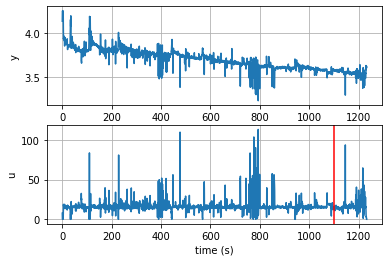

In [7]:
plt.figure()
plt.subplot(211)
plt.plot(t,y)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('y')

plt.subplot(212)
plt.plot(t,u)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('u')
plt.axvline(t[twoi+N-1],color='r')
plt.show()

In [8]:
# block Hankel control matrix

U = u[:twoi]

for n in range(N-1):
    #print(f'n={n}')
    #print(np.shape(U))
    U = np.hstack([U,u[n:twoi+n]])
    #print(U)

In [9]:
print(f'U is {np.shape(U)}')

U is (100, 2000)


In [10]:
# block Hankel observation matrix

Y = y[:twoi]

for n in range(N-1):
    #print(f'n={n}')
    Y = np.hstack([Y,y[n:twoi+n]])
    #print(U)

In [11]:
print(f'Y is {np.shape(Y)}')

Y is (100, 2000)


In [12]:
Up = U[0:i,:] # past inputs
Uf = U[i:,:] # future inputs 
Yp = Y[0:i,:] # past outputs
Yf = Y[i:,:] # future outputs

In [13]:
print(f'Up is {np.shape(Up)}')
print(f'Yp is {np.shape(Yp)}')

Wp = np.vstack([Up,Yp])
print(f'Uf is {np.shape(Uf)}')
print(f'pinv(Uf*Uf.T) is {np.shape(np.linalg.pinv(Uf@Uf.T))}')
PiUf = Uf.T@np.linalg.pinv(Uf@Uf.T)@Uf
print(f'Id is {np.shape(np.identity(np.shape(Uf)[0]))}')
print(f'PiUf is {np.shape(PiUf)}')
PiUfortho = np.identity(np.shape(PiUf)[0]) - PiUf
print(PiUfortho*PiUf)

Up is (50, 2000)
Yp is (50, 2000)
Uf is (50, 2000)
pinv(Uf*Uf.T) is (50, 50)
Id is (50, 50)
PiUf is (2000, 2000)
[[ 9.37645531e-03 -8.96063229e-05 -2.32585118e-05 ... -8.67494852e-08
  -6.23556292e-07 -1.04163501e-06]
 [-8.96063229e-05  9.37645531e-03 -2.32585118e-05 ... -8.67494852e-08
  -6.23556292e-07 -1.04163501e-06]
 [-2.32585118e-05 -2.32585118e-05  9.33774437e-03 ... -1.22200031e-08
  -1.28815588e-07 -5.45566533e-07]
 ...
 [-8.67494852e-08 -8.67494852e-08 -1.22200031e-08 ...  6.76960846e-03
  -7.12803436e-06 -5.12733420e-07]
 [-6.23556292e-07 -6.23556292e-07 -1.28815588e-07 ... -7.12803436e-06
   6.73399414e-03 -6.93499091e-06]
 [-1.04163501e-06 -1.04163501e-06 -5.45566533e-07 ... -5.12733420e-07
  -6.93499091e-06  6.76367513e-03]]


In [14]:
print(f'Yf is {np.shape(Yf)}')
print(f'Wp is {np.shape(Wp)}') # should be 2i long
print(f'PiUfortho is {np.shape(PiUfortho)}')
ksi = (Yf@PiUfortho)@np.linalg.pinv((Wp@PiUfortho))@Wp 
u,s,vh = np.linalg.svd(ksi,compute_uv=True)

Yf is (50, 2000)
Wp is (100, 2000)
PiUfortho is (2000, 2000)


In [15]:
print(f'ksi is {np.shape(ksi)}')
print(f'u is {np.shape(u)}')
print(f's is {np.shape(s)}')
print(f'vh is {np.shape(vh)}')
if i<N :
    Sigma = np.hstack([np.diag(s), np.zeros((i,N-i))])
elif N<i :
    Sigma = np.vstack([np.diag(s), np.zeros((i-N,N))])
else : 
    Sigma = np.diag(s)
print(f'Sigma is {np.shape(Sigma)}')
# Sigma has to be the same shape as ksi
print(f'maximal error is {np.max(ksi-u@Sigma@vh)}')
print(f'Sigma is of rank {np.linalg.matrix_rank(Sigma)}')

ksi is (50, 2000)
u is (50, 50)
s is (50,)
vh is (2000, 2000)
Sigma is (50, 2000)
maximal error is 1.5143442055887135e-13
Sigma is of rank 50


## Modification of the system's order

<IPython.core.display.Javascript object>


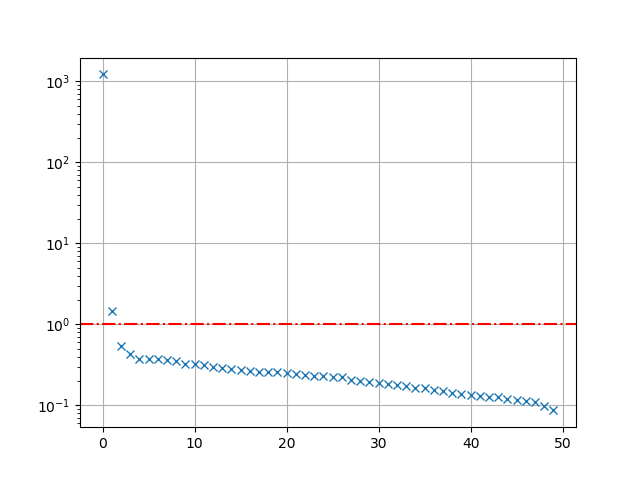

In [20]:
%matplotlib notebook
plt.figure()
plt.axhline(1,color='r',LineStyle='-.')
plt.semilogy(s,'x')
plt.grid()

In [21]:
print(f'Order to be retained is {np.shape(s[s>1])[0]}')
n = 2
print(s[s>1][:10])

Order to be retained is 2
[1220.09644115    1.45760808]


In [22]:
Sigma[Sigma<1] = 0
print(f'Sigma is now of rank {np.linalg.matrix_rank(Sigma)}.')
Sigma = Sigma[:2,:2]
print(np.shape(Sigma))

Sigma is now of rank 2.
(2, 2)


In [26]:
T = np.identity(n) #similarity transformation matrix (has to be square)
print(np.shape(u))
Oi = u@np.sqrt(Sigma)
print(np.shape(Oi))
Oi = Oi@T
print(f'Oi is of shape {np.shape(Oi)} and of rank {np.linalg.matrix_rank(Oi)}')
Xdf = np.linalg.pinv(Oi)@ksi

(50, 50)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 50)

## Compute A and C

In [ ]:
A = pinv(Oi[:-1,:])@Oi[1:,:]
C = Oi[0,:]

In [ ]:
print(np.shape(Oi))

In [ ]:
print(A)
w,v=np.linalg.eig(A) # w are the eigenvalues, v the eigenvectors
print(f'lambda1 = {w[0]}, lambda2 = {w[1]}')
print(np.shape(v))

## Compute B and D

In [ ]:
tmp = Oi.T@np.linalg.inv(Oi@Oi.T)@Oi
Oiortho = np.identity(np.shape(tmp)[0])-tmp
print(Oiortho@Oi) # good

M = Oiortho@Yf@pinv(Uf)
print(M)
M1 = np.reshape(M[:,0],(2,1))
M2 = np.reshape(M[:,1],(2,1))
L1 = np.reshape(Oi[:,0],(2,1))
L2 = np.reshape(Oi[:,1],(2,1))
print(np.shape(M1))
Mb = np.vstack([M1,M2])
Lb = np.hstack([np.vstack([L1,L2]),np.vstack([L2,0*L1])])
print(np.shape(Mb))
print(np.shape(Lb))

Oib = np.vstack([np.hstack([np.identity(1),np.zeros((1,2))]),np.hstack([np.zeros((1,1)),Oi[:-1,:]])])
print(f'Oib is {np.shape(Oib)}, should be {(i,i+1)}')
# Least squares
Phi = Lb@Oib

DB = np.linalg.inv(Phi.T@Phi)@Phi.T@Mb
print(np.shape(DB))
D = DB[0]
B = DB[1:]

## Extract R0, R1 and C1

In [ ]:
R0 = -D[0]
R1 = -C[1]
dt = np.mean(np.diff(t))
C1 = -1/math.log(w[1])*dt/R1

In [ ]:
print(f'R0 = {R0}, R1 = {R1}, C1 = {C1}')